In [73]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import torch
from esm import Alphabet, FastaBatchedDataset, pretrained
import os
import random

#### Question 1: Does dimension reduction into the intrinsic dimensions of the specific protein hold most of its relevant information?
1. Find the [intrinsic dimension of the WT protein](https://huggingface.co/blog/AmelieSchreiber/intrinsic-dimension-of-proteins)
2. Perform PCA over the n dimensions of the mutation data, provided n = WT protein's intrinsic dimension

In [21]:
# get embedding data
model_location = '/./Users/andrewxu/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt'
fasta_file = './data/dms/wt_fasta/jones_WT.fasta'
output_dir = './output'
output_file = 'WT_AA_embeddings'
repr_layers = [-1]

model, alphabet = pretrained.load_model_and_alphabet(model_location)
model.eval()
dataset = FastaBatchedDataset.from_file(fasta_file)
batches = dataset.get_batch_indices(4096, extra_toks_per_seq=1)
data_loader = torch.utils.data.DataLoader(
    dataset, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
)
print(f"Read {fasta_file} with {len(dataset)} sequences")
include = ['per_tok', 'contacts']

# makes sure the representation layer exists, then specifies representation layer(s) in the model
assert all(-(model.num_layers + 1) <= i <= model.num_layers for i in repr_layers)
repr_layers = [(i + model.num_layers + 1) % (model.num_layers + 1) for i in repr_layers]
# repr_layers = 33, ESM2 650M model has 33 layers
with torch.no_grad():
    for batch_idx, (labels, strs, toks) in enumerate(data_loader):
        print(
            f"Processing {batch_idx + 1} of {len(batches)} batches ({toks.size(0)} sequences)"
        )
        
        print(f"Device: {toks.device}")

        return_contacts = "contacts" in include

        # get representation tensor
        out = model(toks, repr_layers=repr_layers, return_contacts=return_contacts)

        logits = out["logits"].to(device="cpu")

        representations = {
            layer: t.to(device="cpu") for layer, t in out["representations"].items()
        }
        if "contacts" in include:
            contacts = out["contacts"].to(device="cpu")

        for i, label in enumerate(labels):
            output_file = os.path.join(output_dir, f"{label}.pt")
            result = {"label": label}
            truncate_len = min(1022, len(strs[i]))
            # Call clone on tensors to ensure tensors are not views into a larger representation
            # See https://github.com/pytorch/pytorch/issues/1995
            if "per_tok" in include:
                result["representations"] = {
                    layer: t[i, 1 : truncate_len + 1].clone()
                    for layer, t in representations.items()
                }
            if "contacts" in include:
                result["contacts"] = contacts[i, : truncate_len, : truncate_len].clone()

            torch.save(
                result,
                output_file,
            )


Read ./data/dms/wt_fasta/jones_WT.fasta with 1 sequences
Processing 1 of 1 batches (1 sequences)
Device: cpu


In [24]:
# convert file to csv
dataframe = []
file_data = torch.load(output_file)
label = file_data['label']
representations = file_data['representations']
key, tensor = representations.popitem()
tensor.shape

/var/folders/dh/zkvslqlx7yjcsf3ltw4jvr_m0000gn/T/ipykernel_1899/1420521935.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file_data = torch.load(output_file)


torch.Size([413, 1280])

In [33]:
embedding_tensor = tensor.numpy()

In [38]:
def compute_persistent_score(embeddings):
    dist_matrix = distance_matrix(embeddings, embeddings)
    mst = minimum_spanning_tree(dist_matrix)
    return mst.sum()

def sample_and_score(embeddings, n, k=8, hat_n=40, J=7):
    scores = []
    sizes = [(i-1) * (n-hat_n) // k + hat_n for i in range(1, k+1)]
    for size in sizes:
        subset_scores = [compute_persistent_score(embeddings[np.random.choice(n, size, replace=False)]) for _ in range(J)]
        scores.append(np.median(subset_scores))
    return sizes, scores

def estimate_dimension(sizes, scores):
    log_sizes = np.log(sizes).reshape(-1, 1)
    log_scores = np.log(scores)
    reg = LinearRegression().fit(log_sizes, log_scores)
    slope = reg.coef_[0]
    return 1/ (1 - slope)

def estimate_sequence_dimension(embeddings, runs=5):
    n = embeddings.shape[0]
    slopes = []
    for _ in range(runs):
        sizes, scores = sample_and_score(embeddings, n)
        log_sizes = np.log(sizes).reshape(-1, 1)
        log_scores = np.log(scores)
        reg = LinearRegression().fit(log_sizes, log_scores)
        slopes.append(reg.coef_[0])
    kappa_f = np.mean(slopes)
    return 1/ (1- kappa_f)


In [39]:
dimension = estimate_sequence_dimension(embedding_tensor)
dimension

16.36544710119416

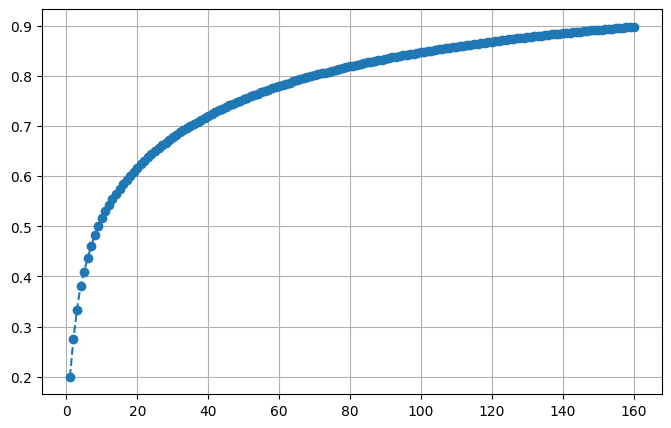

In [58]:
# get pca dimensions and assess their level of "information" per dimension
embedding_path = "./output/dms/embeddings/jones_esm1b_t33_650M_UR50S.csv"
embedding_df = pd.read_csv(embedding_path)
embedding_df = embedding_df.iloc[:, 1:]
pca = PCA(n_components=160)
pca.fit_transform(embedding_df)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o',linestyle='--')
plt.grid(True)
plt.show()


#### Question 2: Is the ground-truth activity labels smooth (i.e. normally distributed) in these low dimensions?
1. For each PCA dimension 1:intrinsic dimension of the protein, map the activity labels and see its distribution

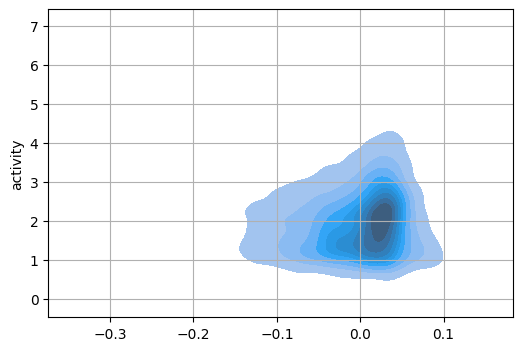

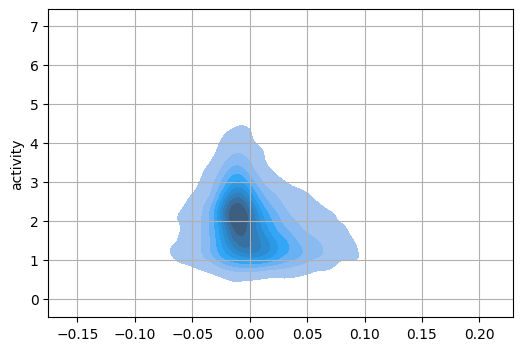

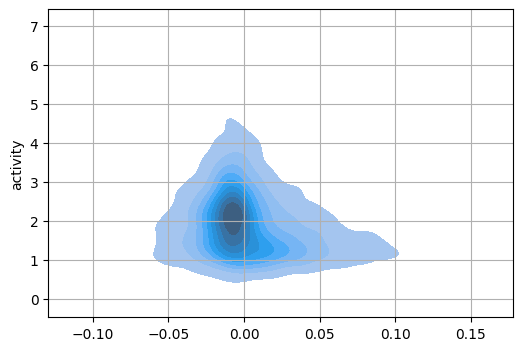

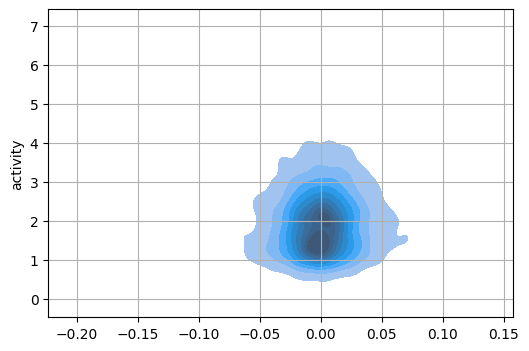

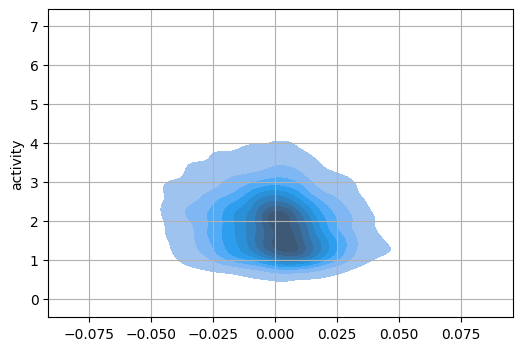

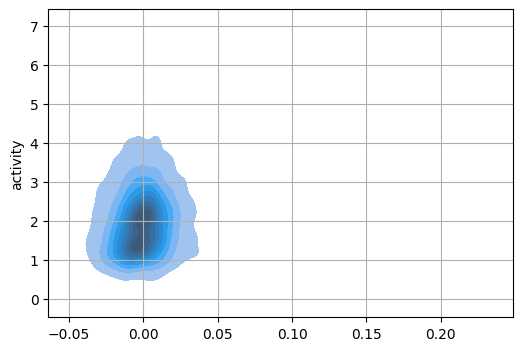

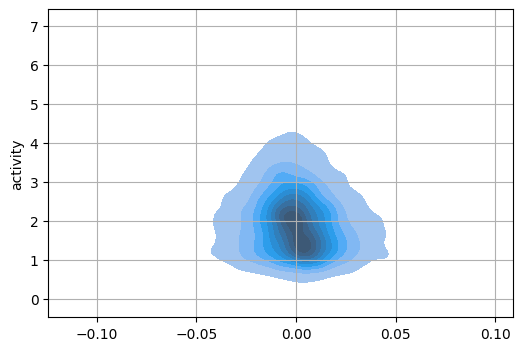

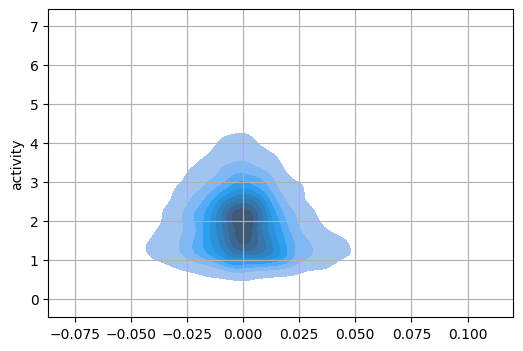

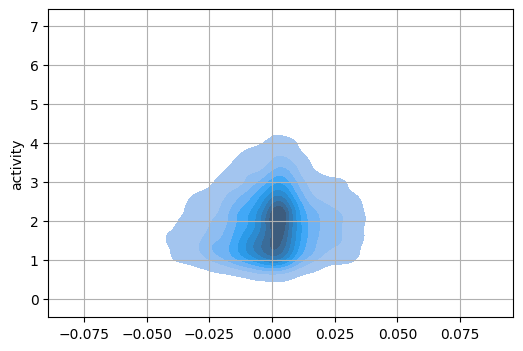

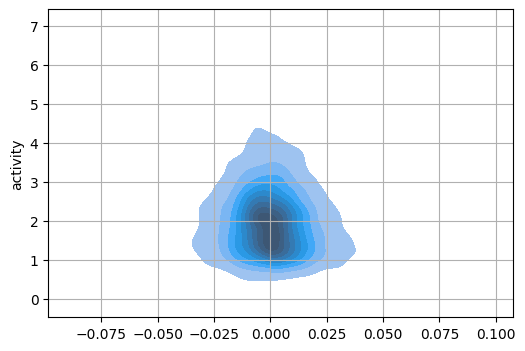

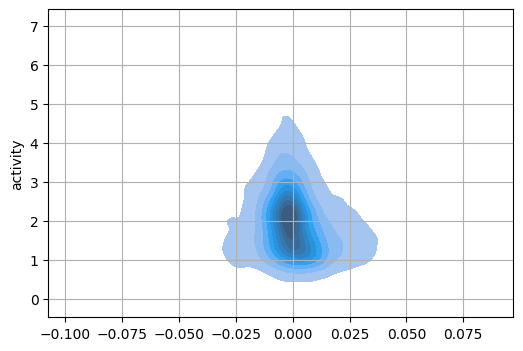

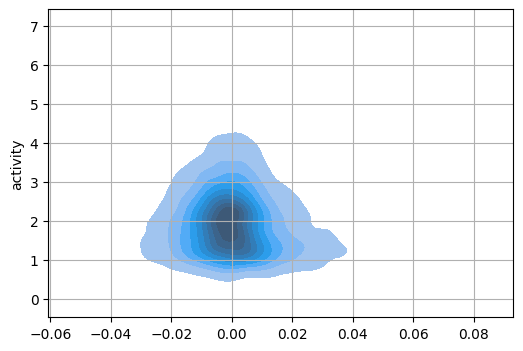

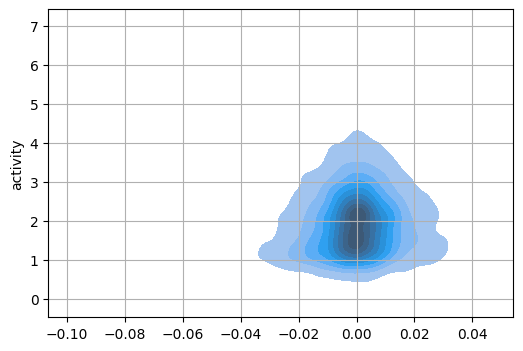

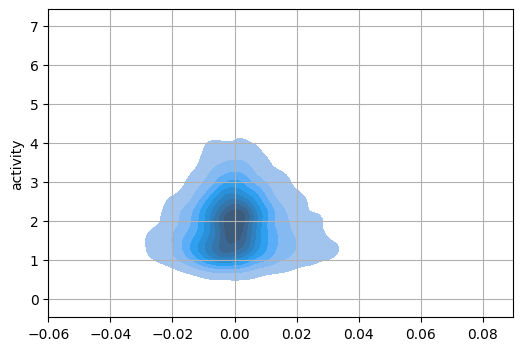

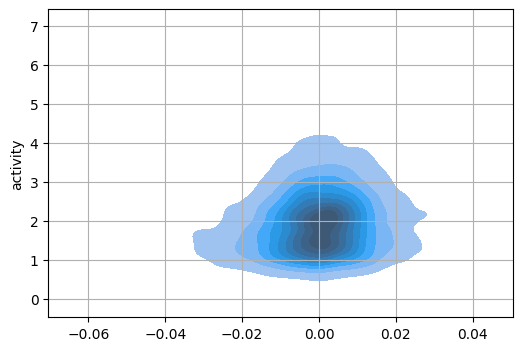

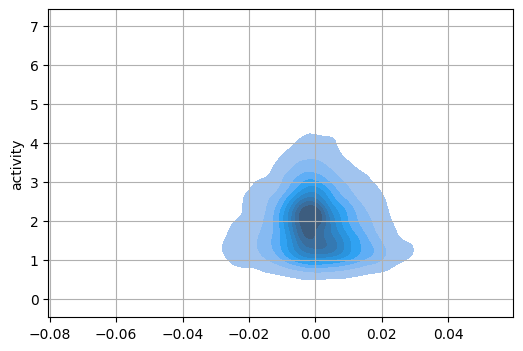

In [72]:
embeddings = pd.read_csv("./output/dms/embeddings/jones_esm1b_t33_650M_UR50S.csv")
variant_order = embeddings.iloc[:, 0].values
embeddings = embeddings.iloc[:, 1:]
labels = pd.read_csv('./output/dms/labels/jones_labels.csv')
labels_sorted = labels.set_index('variant').loc[variant_order].reset_index()
# pca
n_components = 16
pca = PCA(n_components)
pca_result = pca.fit_transform(embeddings)

labels = labels_sorted['activity']
for i in range(n_components):
    plt.figure (figsize=(6,4))
    sns.kdeplot(x=pca_result[:, i], y=labels, fill=True)
    plt.grid(True)
    plt.show()

Sanity check: plot the activity against individual embedding spaces to see what they look like

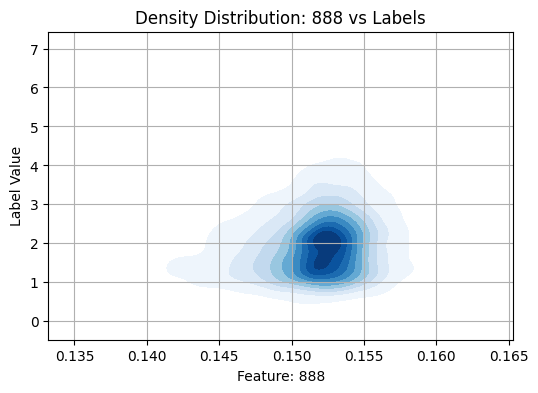

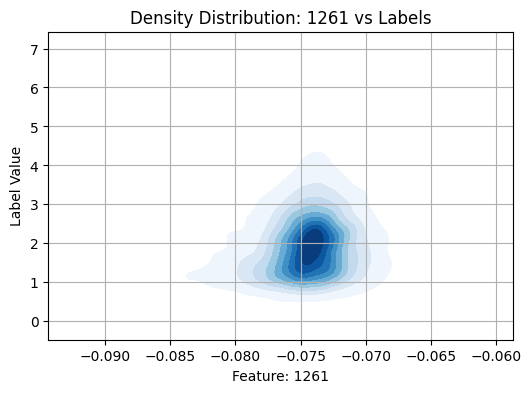

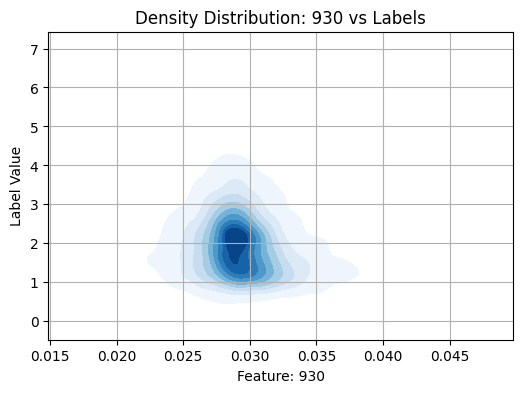

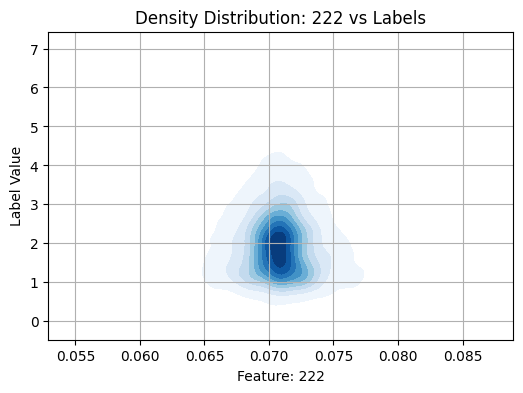

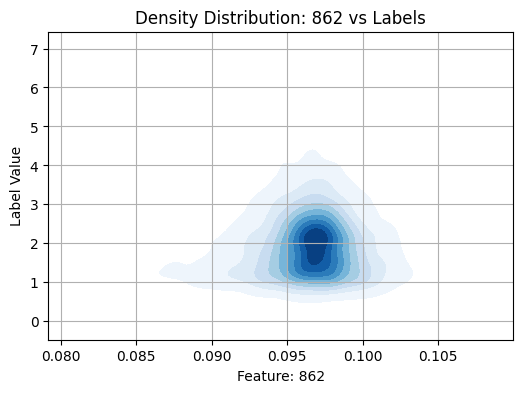

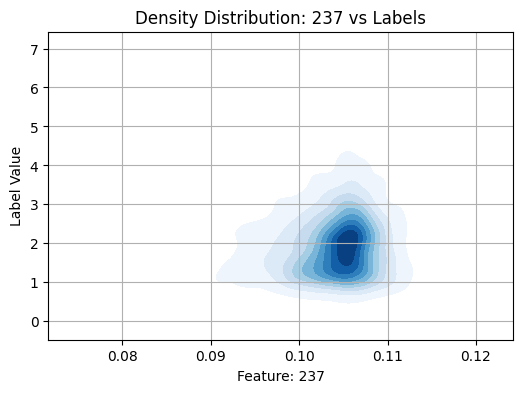

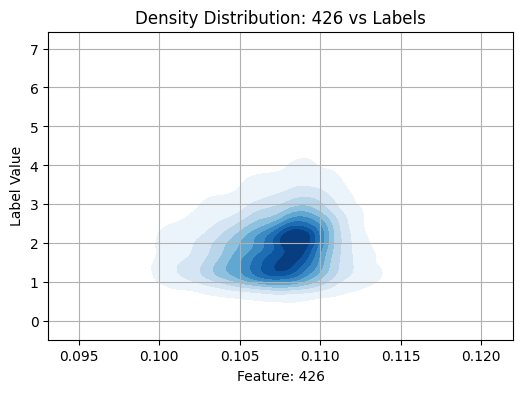

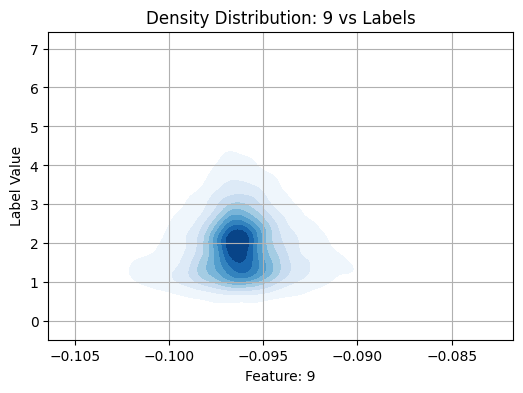

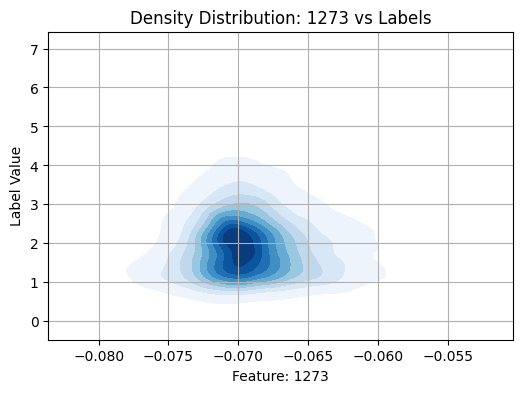

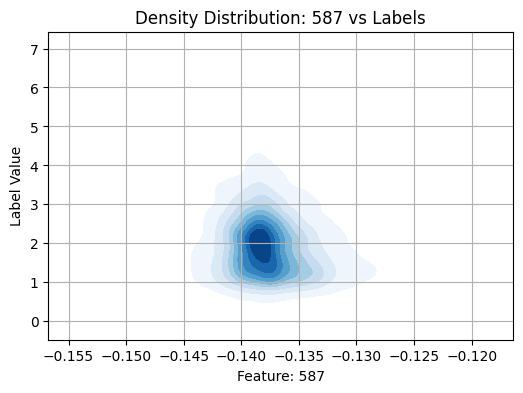

In [74]:
sampled_columns = random.sample(list(embeddings.columns), 10)
sampled_data = embeddings[sampled_columns].values
for i, col_name in enumerate(sampled_columns):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(x=sampled_data[:, i], y=labels, fill=True, cmap="Blues", thresh=0.05)
    plt.xlabel(f'Feature: {col_name}')
    plt.ylabel('Label Value')
    plt.title(f'Density Distribution: {col_name} vs Labels')
    plt.grid(True)
    plt.show() 